### Test 7
## Testing multi view Point-E with occluded object parts
In this notebook we "stress test" Point-E to compare the outputs given respectively a single view and multiple views of an object. This allows us to test prior knowledge on the model from training, and the effective semantic gain in adding new views.
Here, videogame characters should be pretty much out of the training distribution of objects.

In [1]:
from PIL import Image
import torch
from tqdm.auto import tqdm
from torchvision import transforms
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import argparse
from sklearn.neighbors import KernelDensity
from scipy.stats import wasserstein_distance
import os

from mv_point_e.diffusion.configs import DIFFUSION_CONFIGS, diffusion_from_config
from mv_point_e.diffusion.sampler import PointCloudSampler
from mv_point_e.models.download import load_checkpoint
from mv_point_e.models.configs import MODEL_CONFIGS, model_from_config

from mv_point_e.evals.feature_extractor import PointNetClassifier, get_torch_devices
from mv_point_e.evals.fid_is import compute_statistics
from mv_point_e.evals.fid_is import compute_inception_score
import math

In [12]:
from mv_point_e.util.plotting import plot_point_cloud

In [2]:
def views_to_pointcloud(views, n_views=1):
    """ 
        Generate a K-point cloud from a list of n-views
        in:     Tensor(n, w, h, 3), int(n)
        out:    Tensor(1, K, (x, y, z, r, g, b))
    """

    base_name = 'base300M' # base40M, use base300M or base1B for better results

    MODEL_CONFIGS[base_name]["n_views"] = n_views
    MODEL_CONFIGS['upsample']["n_views"] = n_views

    # Instantiate POINT-E and load pre-trained weights
    print('[-] creating base model...')
    base_model = model_from_config(MODEL_CONFIGS[base_name], device)
    base_model.eval()
    base_diffusion = diffusion_from_config(DIFFUSION_CONFIGS[base_name])

    print('[-] creating upsample model...')
    upsampler_model = model_from_config(MODEL_CONFIGS['upsample'], device)
    upsampler_model.eval()
    upsampler_diffusion = diffusion_from_config(DIFFUSION_CONFIGS['upsample'])

    print("[-] Loading pretrained models...")
    base_model.load_state_dict(load_checkpoint(base_name, device))
    upsampler_model.load_state_dict(load_checkpoint('upsample', device))

    sampler = PointCloudSampler(
        device=device,
        models=[base_model, upsampler_model],
        diffusions=[base_diffusion, upsampler_diffusion],
        num_points=[num_points, 4096-num_points], # points in cloud and missing ones for upsampling
        aux_channels=['R', 'G', 'B'],
        guidance_scale=[3.0, 3.0],
    )

    # Produce a sample from the model, iterative diffusion process
    samples = None
    for x in tqdm(sampler.sample_batch_progressive(batch_size=1, model_kwargs=dict(images=views))):
        samples = x

    del sampler
    del base_model
    del base_diffusion
    del upsampler_model
    del upsampler_diffusion

    return samples

# ----------------------------------------------

def cloud_distance(cloud1, cloud2, metric=None):
    """ 
        Compute distance between 1d distributions of cloud p2 norms 
        in:     Tensor((x, y, z), K), Tensor((x, y, z), K) 
        out:    Float
    """
    D1 = torch.cdist(cloud1, cloud1, p=2)
    D2 = torch.cdist(cloud2, cloud2, p=2)
    X1 = [float(1/i.sum()) for i in D1]
    X2 = [float(1/i.sum()) for i in D2]
    
    if metric == "gaussian":
        return np.mean(((np.mean(X1) - np.mean(X2))**2).sum()) / (np.std(X1)**2 + np.std(X2)**2)
    else:
        return wasserstein_distance(X1, X2) * 1e5

# ----------------------------------------------

def plot_distributions(cloud1, cloud2, labels=["cloud1", "cloud2"], idx=0, save_fig=False):
    """ 
        Plot 1d distributions of cloud p2 norms 
        in:     Tensor(K, c), Tensor(K, c) 
    """
    D1 = torch.cdist(cloud1, cloud1, p=2)
    D2 = torch.cdist(cloud2, cloud2, p=2)
    
    s = pd.DataFrame({
        labels[0]: [float(1/i.sum()) for i in D1],
        labels[1]: [float(1/i.sum()) for i in D2],
      })
    s.plot.kde(bw_method=0.4, figsize=(24,8), title=f"Sample {idx} poincloud pdf of different objects")
    
    if save_fig: plt.savefig(f"{idx}_{labels[0]}_{labels[1]}.png")
    
# ----------------------------------------------

def sample_PIS(clf, cloud):
    """
        Compute P-IS score for a cloud
        in:     PointNetClassifier, Tensor(c, K)
        out:    Float
        https://github.com/halixness/point-e/blob/69e677d8ea47593c33fe2f52fd40e131054c9ce3/point_e/evals/fid_is.py#L73
    """
    cloud = cloud.permute(1,0).unsqueeze(0).cpu().numpy()
    _, preds = clf.features_and_preds(cloud)

    return np.exp(
      np.sum(
        preds[0] * ( np.log(preds[0]) - np.log(np.mean(preds[0])) )
      )
    )

# ----------------------------------------------

def batched_PIS(clf, clouds, batch_size=8):
    """
        Computes P-IS score for a batch of point clouds
        in:   PointNetClassifier, (N, K, c)
        out:  Float
    """
    batches = math.ceil(clouds.shape[0] / batch_size)
    dataset_preds = None

    for x in range(batches):
        xs = clouds[(x * batch_size) : ((x + 1) * batch_size)]
        _, preds = clf.features_and_preds(xs)

        if dataset_preds is None: dataset_preds = preds
        else: dataset_preds = np.concatenate((dataset_preds, preds), 0)
            
    return compute_inception_score(dataset_preds)

def batched_PFID(clf, ground_clouds, clouds, batch_size=8):
    """
        Computes P-FID score for pair of batches of point clouds
        in:   PointNetClassifier, (N, K, c), (N, K, c)
        out:  Float
    """
    batches = math.ceil(ground_clouds.shape[0] / batch_size)
    tot_features_1 = None
    tot_features_2 = None

    for x in range(batches):
        
        # Grab batched point clouds to compute the scores
        gnd = ground_clouds[(x * batch_size) : ((x + 1) * batch_size)]
        gen = clouds[(x * batch_size) : ((x + 1) * batch_size)]
        
        features_1, _ = clf.features_and_preds(gnd)
        if tot_features_1 is None: tot_features_1 = features_1
        else: tot_features_1 = np.concatenate((tot_features_1, features_1), 0)
        del features_1

        features_2, _ = clf.features_and_preds(gen)
        if tot_features_2 is None: tot_features_2 = features_2
        else: tot_features_2 = np.concatenate((tot_features_2, features_2), 0)
        del features_2

    stats_1 = compute_statistics(tot_features_1)
    stats_2 = compute_statistics(tot_features_2)    
            
    return stats_1.frechet_distance(stats_2)

**Set-up and data loading**

In [3]:
# Initial parameters 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
ToPILImage = transforms.ToPILImage()
num_points = 1024
limit = 1
default_single_view = 0

In [4]:
import os, random
base_path = os.path.join("..", "..", "..", "Datasets", "PikachuStressTest")
image_size = 256
num_views = 4

images = []
for idx in range(num_views): 
    images.append(
        Image.open(os.path.join(base_path, f"pika_{idx + 1}.png")).resize((image_size, image_size))
    )

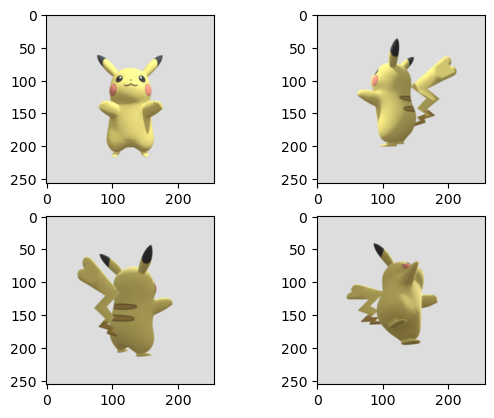

In [5]:
cols = 2
rows = (num_views // cols)
f, axarr = plt.subplots(rows, cols)
for i in range(num_views):
    axarr[i // cols, i % cols].imshow(np.asarray(images[i]))

**Note:** we choose this view for the single view model to "stress test". No pikachu tail!

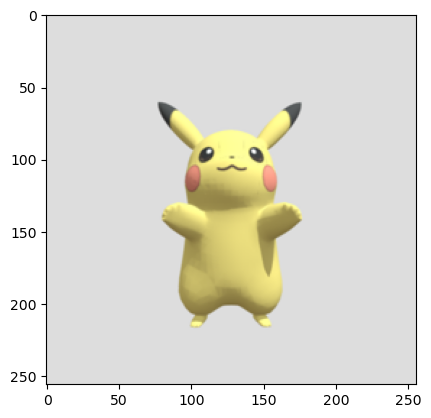

In [6]:
default_view = 0
plt.imshow(images[default_view])

**Generating the point clouds**

In [7]:
# Point cloud from single view
print("====== Single view ======")
single_view_cloud = views_to_pointcloud(views = [images[default_view]], n_views = 1)

torch.cuda.empty_cache()

# Point cloud from multi view
print("\n====== Multi view ======")
multi_view_cloud = views_to_pointcloud(views = images, n_views = len(images))

torch.cuda.empty_cache()

====== Single view ======
[-] creating base model...
[-] Low Res Diff Transformer set with 1024+256*1 input tokens.
[-] creating upsample model...
[-] High Res Diff Transformer set with 3072+256*1 input tokens.
[-] Loading pretrained models...


0it [00:00, ?it/s]


====== Multi view ======
[-] creating base model...
[-] Low Res Diff Transformer set with 1024+256*4 input tokens.
[-] creating upsample model...
[-] High Res Diff Transformer set with 3072+256*4 input tokens.
[-] Loading pretrained models...


0it [00:00, ?it/s]

In [10]:
base_name = 'base300M' # base40M, use base300M or base1B for better results

MODEL_CONFIGS[base_name]["n_views"] = 1
MODEL_CONFIGS['upsample']["n_views"] = 1

# Instantiate POINT-E and load pre-trained weights
print('[-] creating base model...')
base_model = model_from_config(MODEL_CONFIGS[base_name], device)
base_model.eval()
base_diffusion = diffusion_from_config(DIFFUSION_CONFIGS[base_name])

print('[-] creating upsample model...')
upsampler_model = model_from_config(MODEL_CONFIGS['upsample'], device)
upsampler_model.eval()
upsampler_diffusion = diffusion_from_config(DIFFUSION_CONFIGS['upsample'])

print("[-] Loading pretrained models...")
base_model.load_state_dict(load_checkpoint(base_name, device))
upsampler_model.load_state_dict(load_checkpoint('upsample', device))

sampler = PointCloudSampler(
    device=device,
    models=[base_model, upsampler_model],
    diffusions=[base_diffusion, upsampler_diffusion],
    num_points=[num_points, 4096-num_points], # points in cloud and missing ones for upsampling
    aux_channels=['R', 'G', 'B'],
    guidance_scale=[3.0, 3.0],
)

[-] creating base model...
[-] Low Res Diff Transformer set with 1024+256*1 input tokens.
[-] creating upsample model...
[-] High Res Diff Transformer set with 3072+256*1 input tokens.
[-] Loading pretrained models...


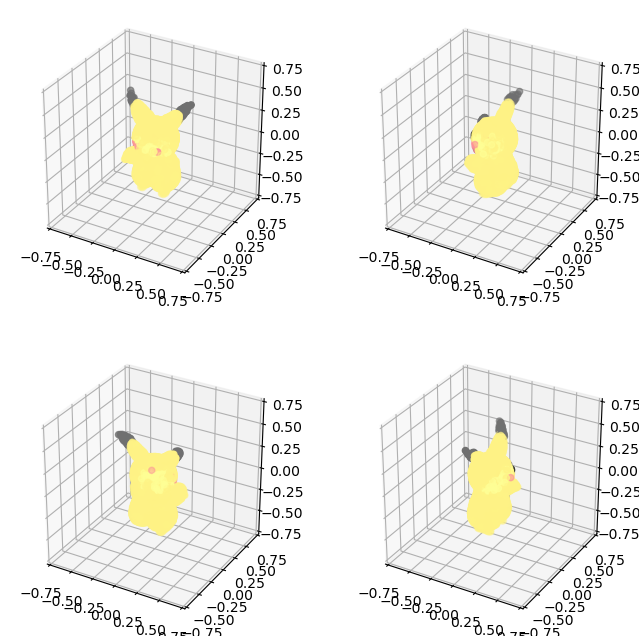

In [13]:
pc = sampler.output_to_point_clouds(single_view_cloud)[0]
fig = plot_point_cloud(pc, grid_size=2, fixed_bounds=((-0.75, -0.75, -0.75),(0.75, 0.75, 0.75)))

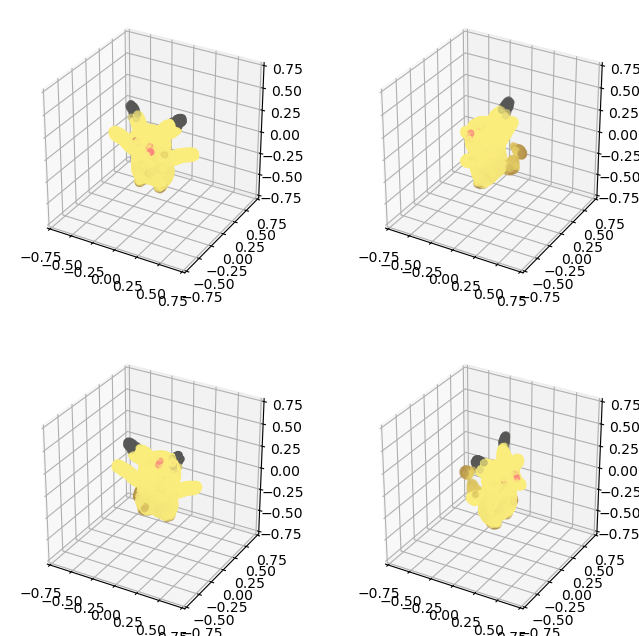

In [20]:
pc = sampler.output_to_point_clouds(multi_view_cloud)[0]
fig = plot_point_cloud(pc, grid_size=2, fixed_bounds=((-0.75, -0.75, -0.75),(0.75, 0.75, 0.75)))

In [21]:
# Load PointNet to classify point clouds (and derive semantic score)
clf = PointNetClassifier(devices=get_torch_devices(), cache_dir=None)


====== [3] Point cloud divergences ======
[+] single view - multi view divergence: 		0.014373472367879003


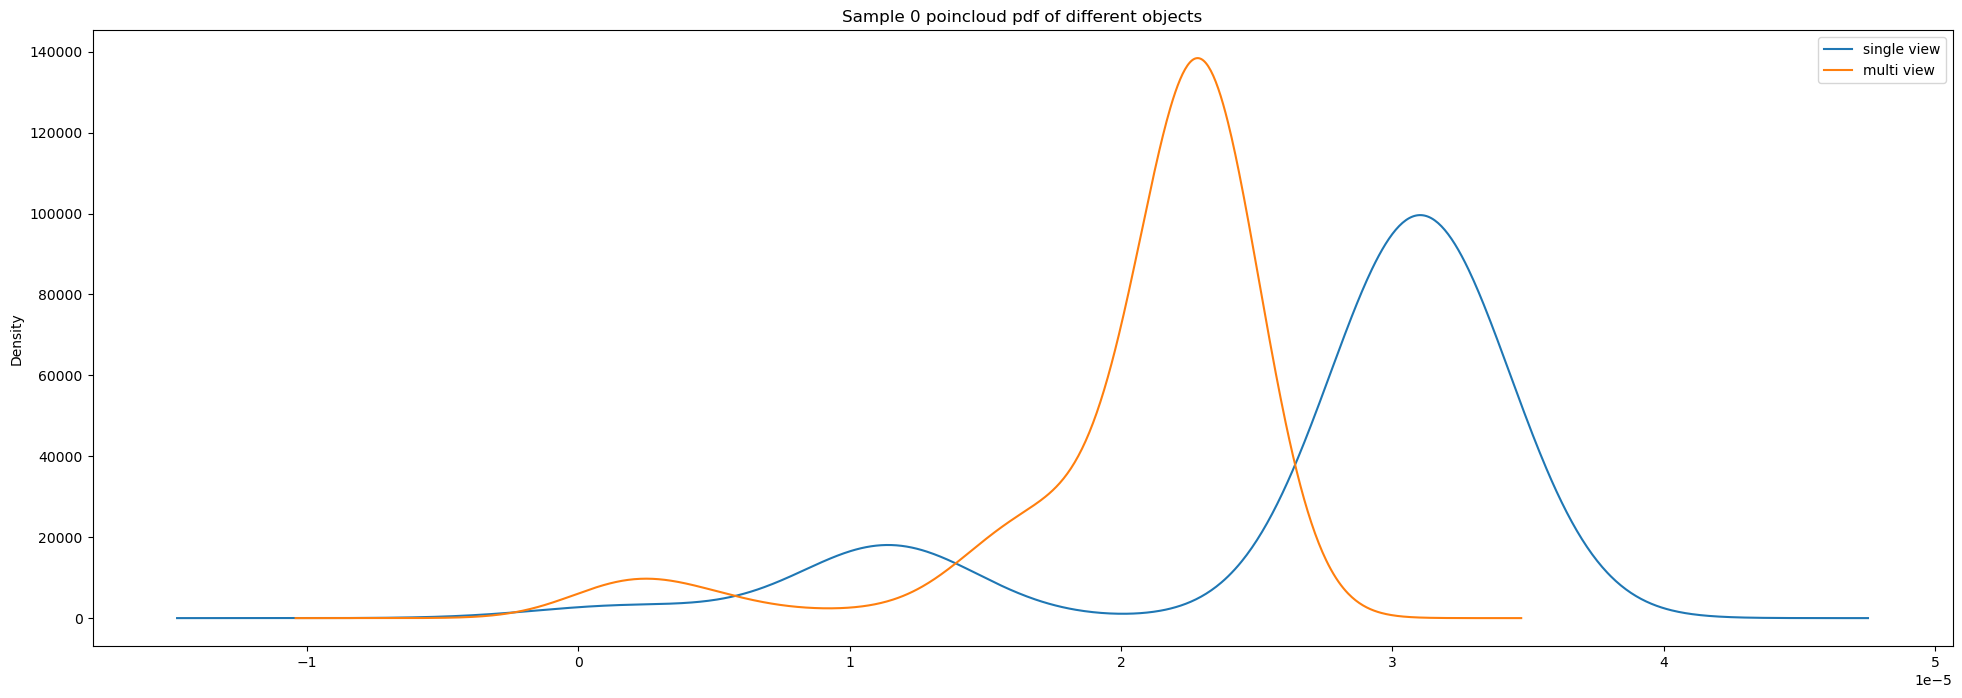

In [26]:
print(f"\n====== [{i}] Point cloud divergences ======")

# ---- ground truth cloud / single view cloud
d_ground_single = cloud_distance(
    torch.Tensor(single_view_cloud), 
    torch.Tensor(multi_view_cloud)
)

print("[+] single view - multi view divergence: \t\t{}".format(d_ground_single))

plot_distributions(
    torch.Tensor(single_view_cloud)[0].permute(1,0), 
    torch.Tensor(multi_view_cloud)[0].permute(1,0),
    ["single view", "multi view"]
)